### Import dependencies and functions needed

In [2]:
import pandas as pd
import math
import numpy as np
import datetime as dt
import yfinance as yf
from numpy import linalg as la
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import statistics
import os
from PIL import Image as img

#we define our functions on this cell. 

def ComputePCA_GPS(S, Srank, Sdim):
#
# function to compute PCA and GPS estimators of b given sample cov. matrix S
# and rank Srank, which will equal the number of periods. 
# Sdim = size of S = num of assets.
# There are Srank nonzero evalues, Srank -1 of them below the leading evalue
#
    evalues, evectors = la.eigh(S)  # S a sym matrix of size MaxAssets, rank Srank
    h = evectors[:, Sdim - 1]  # normalized evector corr. to largest evalue of S
    sp2 = evalues[Sdim - 1]  # leading evalue of S
    lp2 = (np.sum(evalues)-sp2)/(Srank -1) # average of the lesser nonzero evalues
    psi2 = (sp2 - lp2)/sp2  # this is the psi^2 term from the GPS paper
    all_ones = np.ones(Sdim)
    q = all_ones/la.norm(all_ones)  # north pole, unit vector
    
    hq = np.dot(h,q)  # inner product of h and q
    if hq < 0:
        h = -h      # choose e-vector h with positive mean
        hq = -hq
    elif hq == 0:
        print("error: h is orthogonal to q")

    tau = (1-psi2)*hq/(psi2 - hq*hq) # gps data driven shrinkage parameter
    h_shr = h + tau*q   # h_GPS before normalizing
    return h, (1/la.norm(h_shr))*h_shr, sp2, lp2  # h and h_GPS, normalized, and sp2, lp2

def ComputeMRPortfolio(p, p_eta, delta2, h):

# outputs w = argmin w^T Sigma w, subj to w^T e = 1.
# Here Sigma is the real or estimated covariance matrix, depending on inputs
# p = dimension of Sigma = number of assets
# p_eta, delta2, h determine Sigma = p_eta hh^T + delta2 I
# Notation follows MAPS, section 3

    all_ones = np.ones(p)
    q = all_ones/la.norm(all_ones)  # north pole, unit vector
    hq = np.dot(h,q)

    k2 = delta2/p_eta
    rho = (1+k2)/hq
    w = ((rho*q)-h)/((rho - hq)*np.sqrt(p))
    return w


def inSampleTest(period, time_interval, num_assets, tframe):
    
#valid periods: '1mo', '3mo', '6mo' ,'1y', '2y', '5y', '10y', 'max' 
#valid time interval: '1d', '5d', '1wk', '1mo', '3mo'
#tframe is simply window loops during the period for this many days or months, e.g. tframe = 24 on a month interval is 2 years of monthly data.

    #pulling and cleaning data
    df = pd.read_excel("D:\HITM\JSE code\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] #collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) #organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = time_interval)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') #cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)

    #the insample test

    #variance list
    varJSE = []
    varPCA = []
    varRAW = []

    #list of portfolio weights for each period
    p_JSE = []
    p_PCA = []
    p_RAW = []

    #computeInSampleVar():
    
    for i in range(0,len(sampleData_pct)-tframe): #subtract 2 from the length i
        tempdf = sampleData_pct.iloc[i:tframe+i, :] #current month frame
        tempSample_cov = tempdf.cov() 
        
        rank = len(tempdf)
        dimension = len(tempSample_cov)
        
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) #leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    # estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) # estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) # PCA evalue and evector
        
        #all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        #variances
        
        jse_var = np.dot(w_Ejse, np.dot(tempSample_cov, w_Ejse))
        pca_var = np.dot(w_Epca, np.dot(tempSample_cov, w_Epca))
        raw_var = np.dot(w_raw, np.dot(tempSample_cov, w_raw))
        
        #appending current in sample variance to the list
        
        varJSE.append(jse_var)
        varPCA.append(pca_var)
        varRAW.append(raw_var)

    return varJSE, varPCA, varRAW

def outSampleTest(period, time_interval, num_assets, tframe): 
    #pulling and cleaning data
    df = pd.read_excel("D:\HITM\JSE code\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] #collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) #organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = time_interval)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') #cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)

    #the rollling out of sample test
    
    #list of portfolio weights per iteration
    p_JSE = []
    p_PCA = []
    p_RAW = []
    
    #list of portfolio returns
    p_returnJSE = []
    p_returnPCA = []
    p_returnRAW = []
    
    #computeOutSampleVar():
    
    for i in range(0,len(sampleData_pct)-tframe): #subtract 2 from the length i
        tempdf = sampleData_pct.iloc[i:tframe+i, :] #current month frame
        tempSample_cov = tempdf.cov()
        
        rank = len(tempdf)
        dimension = len(tempSample_cov)
        
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) #leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    # estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) # estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) # PCA evalue and evector
        
        #all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        #variances out of sample

        p_returnJSE.append(np.dot(sampleData_pct.iloc[tframe+i], w_Ejse))
        p_returnPCA.append(np.dot(sampleData_pct.iloc[tframe+i], w_Epca))
        p_returnRAW.append(np.dot(sampleData_pct.iloc[tframe+i], w_raw))
        
    #taking the variance of the out of sample portfolio returns
    jse_var = statistics.variance(p_returnJSE)
    pca_var = statistics.variance(p_returnPCA)
    raw_var = statistics.variance(p_returnRAW)
        

    return jse_var, pca_var, raw_var #variance of portfolio returns

#bias test returns a list of standard deviations for JSE, PCA, RAW. It is our job to use a sliding window after this is done

def biasTest(period, time_interval, num_assets, tframe): 
    #pulling and cleaning data
    df = pd.read_excel("D:\HITM\JSE code\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] #collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) #organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = time_interval)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') #cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    
    #the bias test
    
    #array of portfolio weights
    p_JSE = []
    p_PCA = []
    p_RAW = []
    
    #list of model standard deviations
    pnorm_JSE = []
    pnorm_PCA = []
    pnorm_RAW = []
    
    iterations = 0
    # pnorm_METHOD will be a collection of normalized returns, w
    
    for i in range(0,len(sampleData_pct)-tframe-2): #subtract 1 from the length i (we use "next month" data)
        tempdf = sampleData_pct.iloc[i:tframe+i, :] #current month frame
        tempdf = tempdf.apply(lambda x: x - x.mean(axis = 0)) #demean the asset returns of the current window frame using current asset window frame means
        tempSample_cov = tempdf.cov()
        
        tempdf2 = sampleData_pct.iloc[i:tframe+i+1, :]
        tempdf2 = tempdf2.apply(lambda x: x - x.mean(axis = 0))
        
        rank = len(tempdf)
        dimension = len(tempSample_cov)
        
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) #leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    # estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) # estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) # PCA evalue and evector
        
        #all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        #std of model
        
        cur_jse_std = math.sqrt(np.dot(w_Ejse, np.dot(tempSample_cov, w_Ejse)))
        cur_pca_std = math.sqrt(np.dot(w_Epca, np.dot(tempSample_cov, w_Epca)))
        cur_raw_std = math.sqrt(np.dot(w_raw, np.dot(tempSample_cov, w_raw)))
        
        #next month portoflios return/std

        pnorm_JSE.append((np.dot(tempdf2.iloc[-1], w_Ejse))/cur_jse_std)
        pnorm_PCA.append((np.dot(tempdf2.iloc[-1], w_Epca))/cur_pca_std)
        pnorm_RAW.append((np.dot(tempdf2.iloc[-1], w_raw))/cur_raw_std)
        
        iterations += 1
        
    std_pnorm_JSE = np.std(pnorm_JSE)
    std_pnorm_PCA = np.std(pnorm_PCA)
    std_pnorm_RAW = np.std(pnorm_RAW)
    

    return pnorm_JSE, pnorm_PCA, pnorm_RAW, iterations


### In sample test

In [2]:
varJSE, varPCA, varRAW = inSampleTest('10y', '1mo', 50, 24)

[*********************100%***********************]  50 of 50 completed


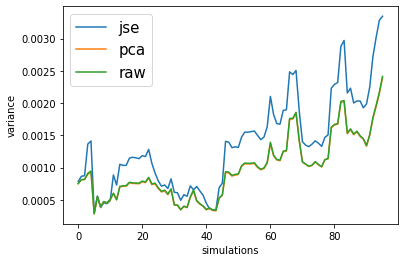

In [3]:
plt.plot(varJSE, label = 'jse')
plt.plot(varPCA, label = 'pca')
plt.plot(varRAW, label = 'raw')
plt.xlabel("simulations")
plt.ylabel("variance")
plt.rcParams["figure.figsize"] = (15,10)
plt.legend(prop = {'size': 15})
plt.rcParams.update({'font.size': 8})
plt.show()

### Out of sample test

In [4]:
os_varJSE, os_varPCA, os_varRAW = outSampleTest('10y', '1mo', 50, 24)

[*********************100%***********************]  50 of 50 completed


In [5]:
var_list = [os_varJSE, os_varPCA, os_varRAW]

In [6]:
for i in var_list: 
    print(i)

0.0018639845854092796
0.0016047461416997032
0.0016097268857019021


### Bias testing

In [33]:
varJSE, varPCA, varRAW, iterations = biasTest('1y', '1d', 50, 24)

[*********************100%***********************]  50 of 50 completed


In [34]:
varJSE

[-0.16132952858313623,
 0.4467028324259689,
 -0.1537302294283482,
 0.578679314452087,
 0.3720469013999627,
 -0.37406460948005704,
 1.1081488593371294,
 -0.4974042473401127,
 0.2779380226125555,
 -0.41523049223180636,
 -0.4122170721913914,
 0.013448964616074484,
 0.7791374291359373,
 -0.7652149552569015,
 -0.47548168176586864,
 0.3747605545893238,
 -1.736992160356281,
 0.7732787826253569,
 -0.9203944675520338,
 -0.07984006363762869,
 1.735516905483015,
 1.7196305635417002,
 1.199203648303492,
 -2.169762687435016,
 -0.49046967871111763,
 -0.21696334616813961,
 -0.24962886530854075,
 -1.132134432181813,
 0.17499173877185162,
 1.4209604486570762,
 -1.1613358797039772,
 -3.6188753875468405,
 -0.3345835681561082,
 -0.4061822020112773,
 0.2125719507262972,
 0.481160449395424,
 -2.2074702114763785,
 -1.1503334568304784,
 0.3525618099010594,
 1.3950726627322017,
 0.1608536032922599,
 0.44335228491767287,
 -0.02274732126449308,
 -0.9489447755033273,
 1.0408607909010348,
 0.47926646634165027,
 -0

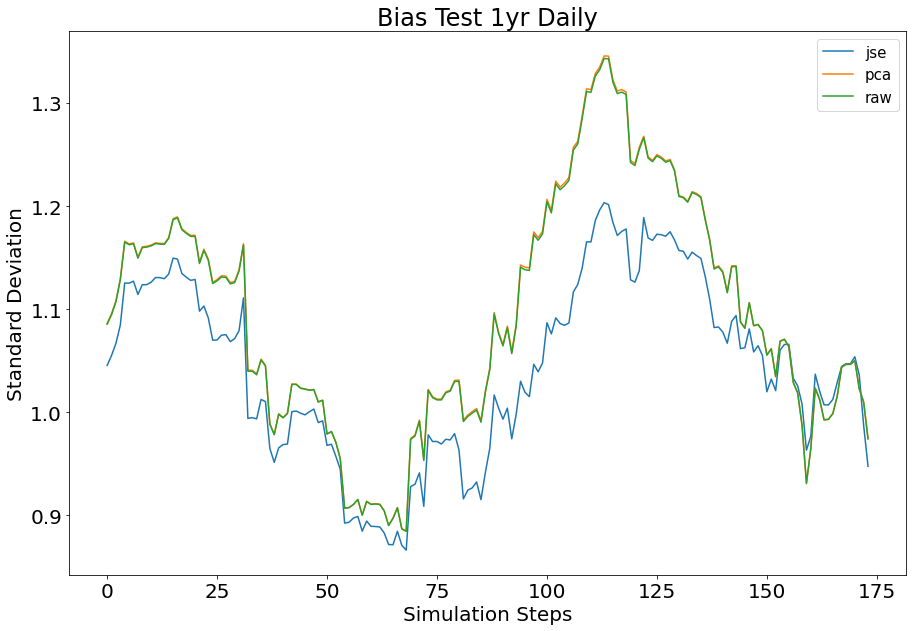

In [54]:
myJSE = []
myRAW = []
myPCA = []
for i in range(iterations-50): 
    myJSE.append(np.std(varJSE[i:50+i]))
    myRAW.append(np.std(varRAW[i:50+i]))
    myPCA.append(np.std(varPCA[i:50+i]))

plt.plot(myJSE, label = 'jse')
plt.plot(myPCA, label = 'pca')
plt.plot(myRAW, label = 'raw')
plt.xlabel("Simulation Steps")
plt.ylabel("Standard Deviation")
plt.title("Bias Test 1yr Daily")
plt.rcParams["figure.figsize"] = (15,10)
plt.legend(prop = {'size': 15})
plt.rcParams.update({'font.size': 20})


plt.savefig("BT_1_dd", dpi = 300, bbox_inches='tight')
plt.show()

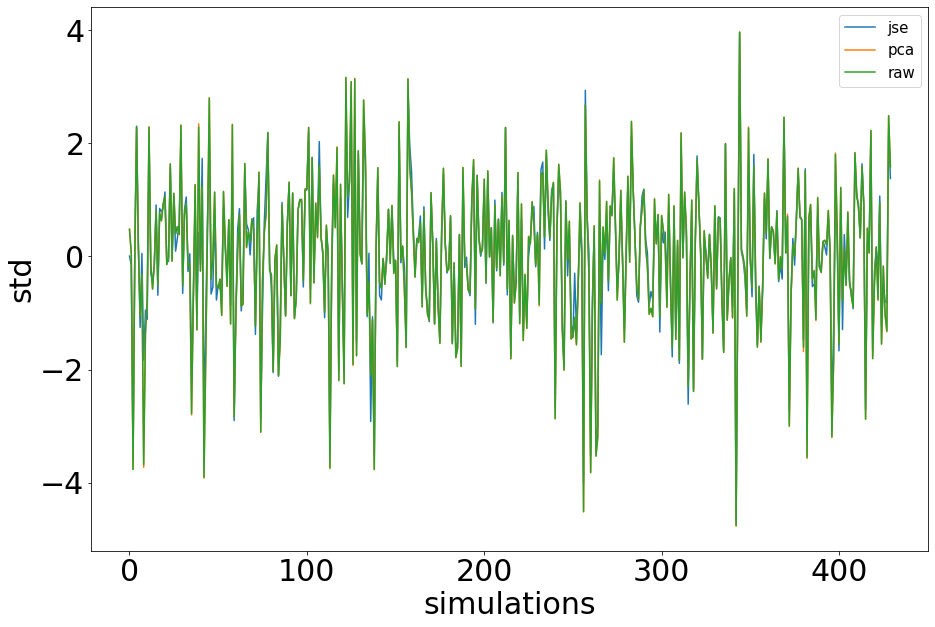

In [15]:
plt.plot(varJSE, label = 'jse')
plt.plot(varPCA, label = 'pca')
plt.plot(varRAW, label = 'raw')
plt.xlabel("simulations")
plt.ylabel("std")
plt.rcParams["figure.figsize"] = (15,10)
plt.legend(prop = {'size': 15})
plt.rcParams.update({'font.size': 8})
plt.show()

In [46]:
os.listdir()

['.ipynb_checkpoints',
 'Bias Test 1yr Daily.png',
 'JSE_first_sim-Copy1.ipynb',
 'JSE_first_sim.ipynb',
 'JSE_first_sim_TEMPPPP.ipynb',
 'JSE_IS_OS_BT.ipynb',
 'temp_JSE_SIM.ipynb',
 'Untitled.ipynb',
 'Untitled1.ipynb']

In [3]:
np.zeros((3,3,5))

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [7]:
np.random.normal(1, 0, 500).shape

(500,)

In [19]:
betas = np.random.randn(1,5)
betas

array([[-1.9670887 , -1.61211495, -0.20355843, -0.25436548, -0.44996444]])

In [27]:
fact_ret = np.array([ [[1,2,3],
                       [4,5,6]],[[7,8,9],
                                 [7,8,9]] ])
fact_ret[:,:,0]

array([[1, 4],
       [7, 7]])

In [23]:
np.outer(betas, fact_ret)

array([[-1.9670887 , -1.9670887 , -1.9670887 ],
       [-1.61211495, -1.61211495, -1.61211495],
       [-0.20355843, -0.20355843, -0.20355843],
       [-0.25436548, -0.25436548, -0.25436548],
       [-0.44996444, -0.44996444, -0.44996444]])